### Langchain - Chains 

Chain combines LLM together with Prompts which will be termed as Building block.

You can chain multiple Building blocks to carry out a sequence of operations on your text.

#### Outline

* LLMChain
* Sequential Chains
  * SimpleSequentialChain
  * SequentialChain
* Router Chain

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

# account for deprecation of LLM model
import datetime
# Get the current date
current_date = datetime.datetime.now().date()

# Define the date after which the model should be set to "gpt-3.5-turbo"
target_date = datetime.date(2024, 6, 12)

# Set the model variable based on the current date
if current_date > target_date:
    llm_model = "gpt-3.5-turbo"
else:
    llm_model = "gpt-3.5-turbo-0301"

import pandas as pd
df = pd.read_csv('Data.csv')

df.head()

,Product,Review
0,Queen Size Sheet Set,I ordered a king size set. My only criticism w...
1,Waterproof Phone Pouch,"I loved the waterproof sac, although the openi..."
2,Luxury Air Mattress,This mattress had a small hole in the top of i...
3,Pillows Insert,This is the best throw pillow fillers on Amazo...
4,Milk Frother Handheld\n,I loved this product. But they only seem to l...


#### LLM Chain

In [2]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

llm = ChatOpenAI(temperature=0.9, model=llm_model)

prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

chain = LLMChain(llm=llm, prompt=prompt)

product = "Queen Size Sheet Set"
chain.run(product)

'"Royal Comfort Home Textiles" could be a good name for a company that makes Queen Size Sheet Sets.'

#### Sequential Chain 

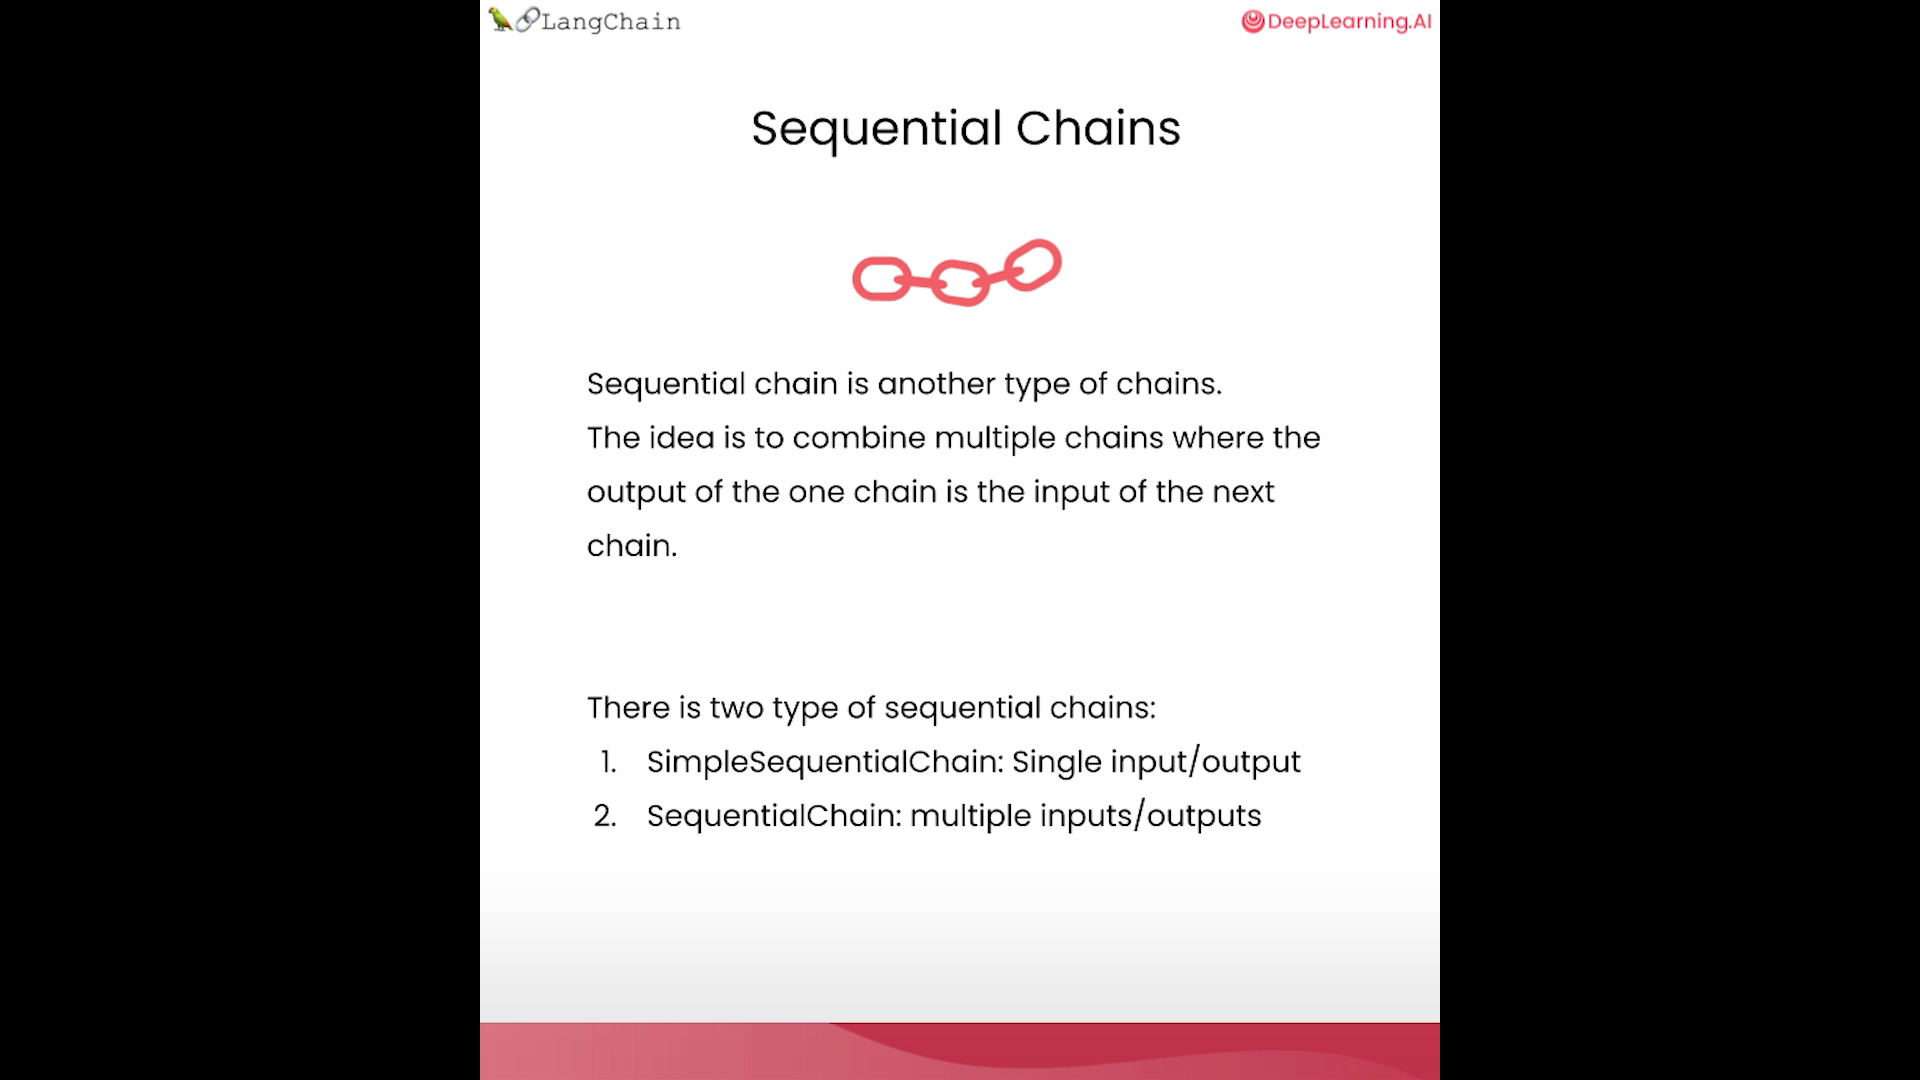

SimpleSequentialChain

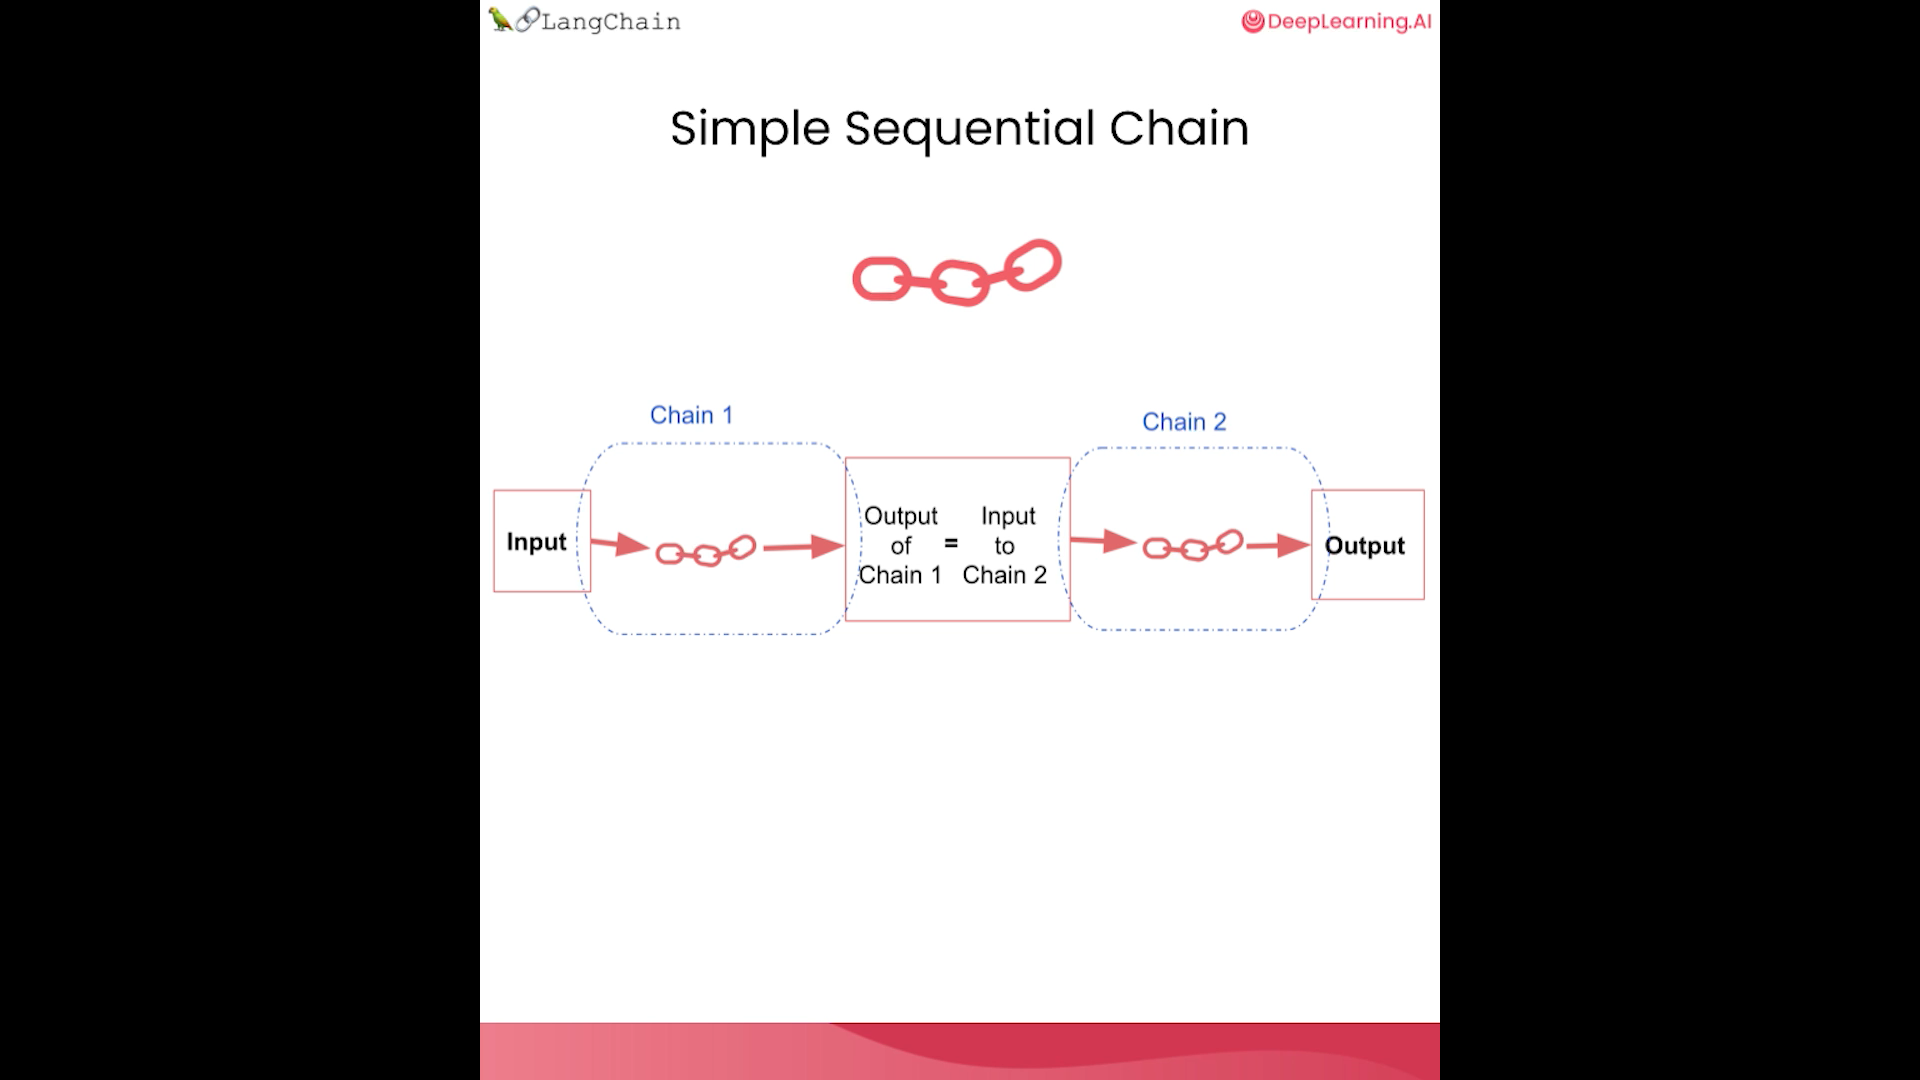

In [3]:
from langchain.chains import SimpleSequentialChain

llm = ChatOpenAI(temperature=0.9, model=llm_model)

# prompt template 1
first_prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

# Chain 1
chain_one = LLMChain(llm=llm, prompt=first_prompt)

# prompt template 2
second_prompt = ChatPromptTemplate.from_template(
    "Write a 20 words description for the following \
    company:{company_name}"
)
# chain 2
chain_two = LLMChain(llm=llm, prompt=second_prompt)

overall_simple_chain = SimpleSequentialChain(chains=[chain_one, chain_two],
                                             verbose=True
                                            )

overall_simple_chain.run(product) ## product - "Queen Size Sheet Set"



> Entering new SimpleSequentialChain chain...
Royal Linens.
Royal Linens is a luxurious bedding and bath linens brand that offers top-quality products for a comfortable and stylish home.

> Finished chain.


'Royal Linens is a luxurious bedding and bath linens brand that offers top-quality products for a comfortable and stylish home.'

SequentialChain

Will be used when there are multiple inputs and output.

Also you will get output for each chain used 

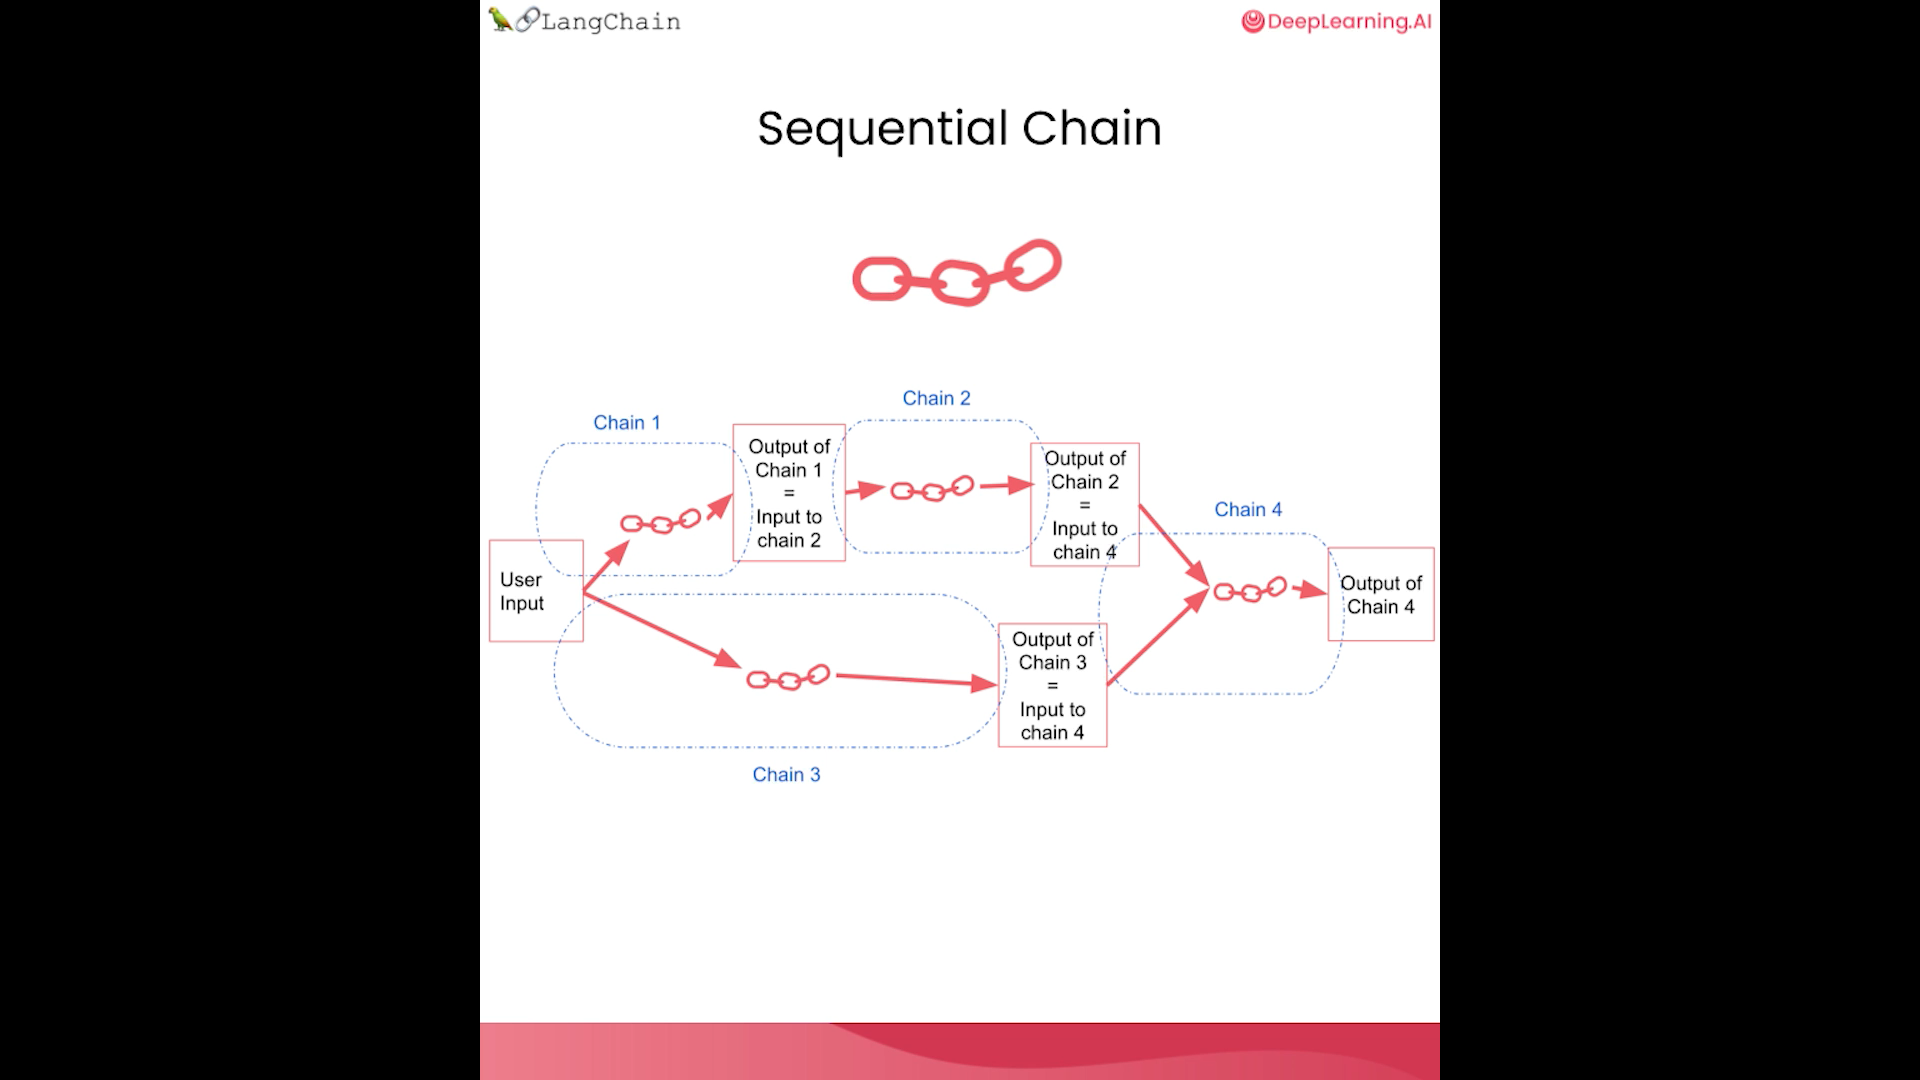

In [4]:
from langchain.chains import SequentialChain
llm = ChatOpenAI(temperature=0.9, model=llm_model)

# prompt template 1: translate to english
first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to english:"
    "\n\n{Review}"
)
# chain 1: input= Review and output= English_Review
chain_one = LLMChain(llm=llm, prompt=first_prompt, 
                     output_key="English_Review"
                    )

second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:"
    "\n\n{English_Review}"
)
# chain 2: input= English_Review and output= summary
chain_two = LLMChain(llm=llm, prompt=second_prompt, 
                     output_key="summary"
                    )

# prompt template 3: translate to english
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{Review}"
)
# chain 3: input= Review and output= language
chain_three = LLMChain(llm=llm, prompt=third_prompt,
                       output_key="language"
                      )

# prompt template 4: follow up message
fourth_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following "
    "summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)
# chain 4: input= summary, language and output= followup_message
chain_four = LLMChain(llm=llm, prompt=fourth_prompt,
                      output_key="followup_message"
                     )

# overall_chain: input= Review 
# and output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three, chain_four],
    input_variables=["Review"],
    output_variables=["English_Review", "summary","followup_message"],
    verbose=True
)


In [5]:
review = df.Review[5]
overall_chain(review)



> Entering new SequentialChain chain...


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.co


> Finished chain.


{'Review': "Je trouve le goût médiocre. La mousse ne tient pas, c'est bizarre. J'achète les mêmes dans le commerce et le goût est bien meilleur...\nVieux lot ou contrefaçon !?",
 'English_Review': '"I find the taste mediocre. The foam doesn\'t hold, it\'s weird. I buy the same ones in stores and the taste is much better...Old batch or counterfeit!?"',
 'summary': "The reviewer found the taste mediocre and suggested that the product might be an old batch or counterfeit since the foam doesn't hold as well as those bought in stores.",
 'followup_message': 'Réponse: Nous sommes désolés que vous ayez trouvé le goût du produit médiocre. Nous aimerions souligner que tous nos produits sont fabriqués avec les ingrédients les plus frais et de la plus haute qualité. Nous prenons également des mesures strictes pour prévenir les contrefaçons de nos produits. Nous vous encourageons à nous contacter directement pour que nous puissions enquêter sur ce que vous avez reçu. Nous apprécions votre avis et 

#### Router Chain

Route it to a specific chain . If output of previous chain is related to that specific chain 

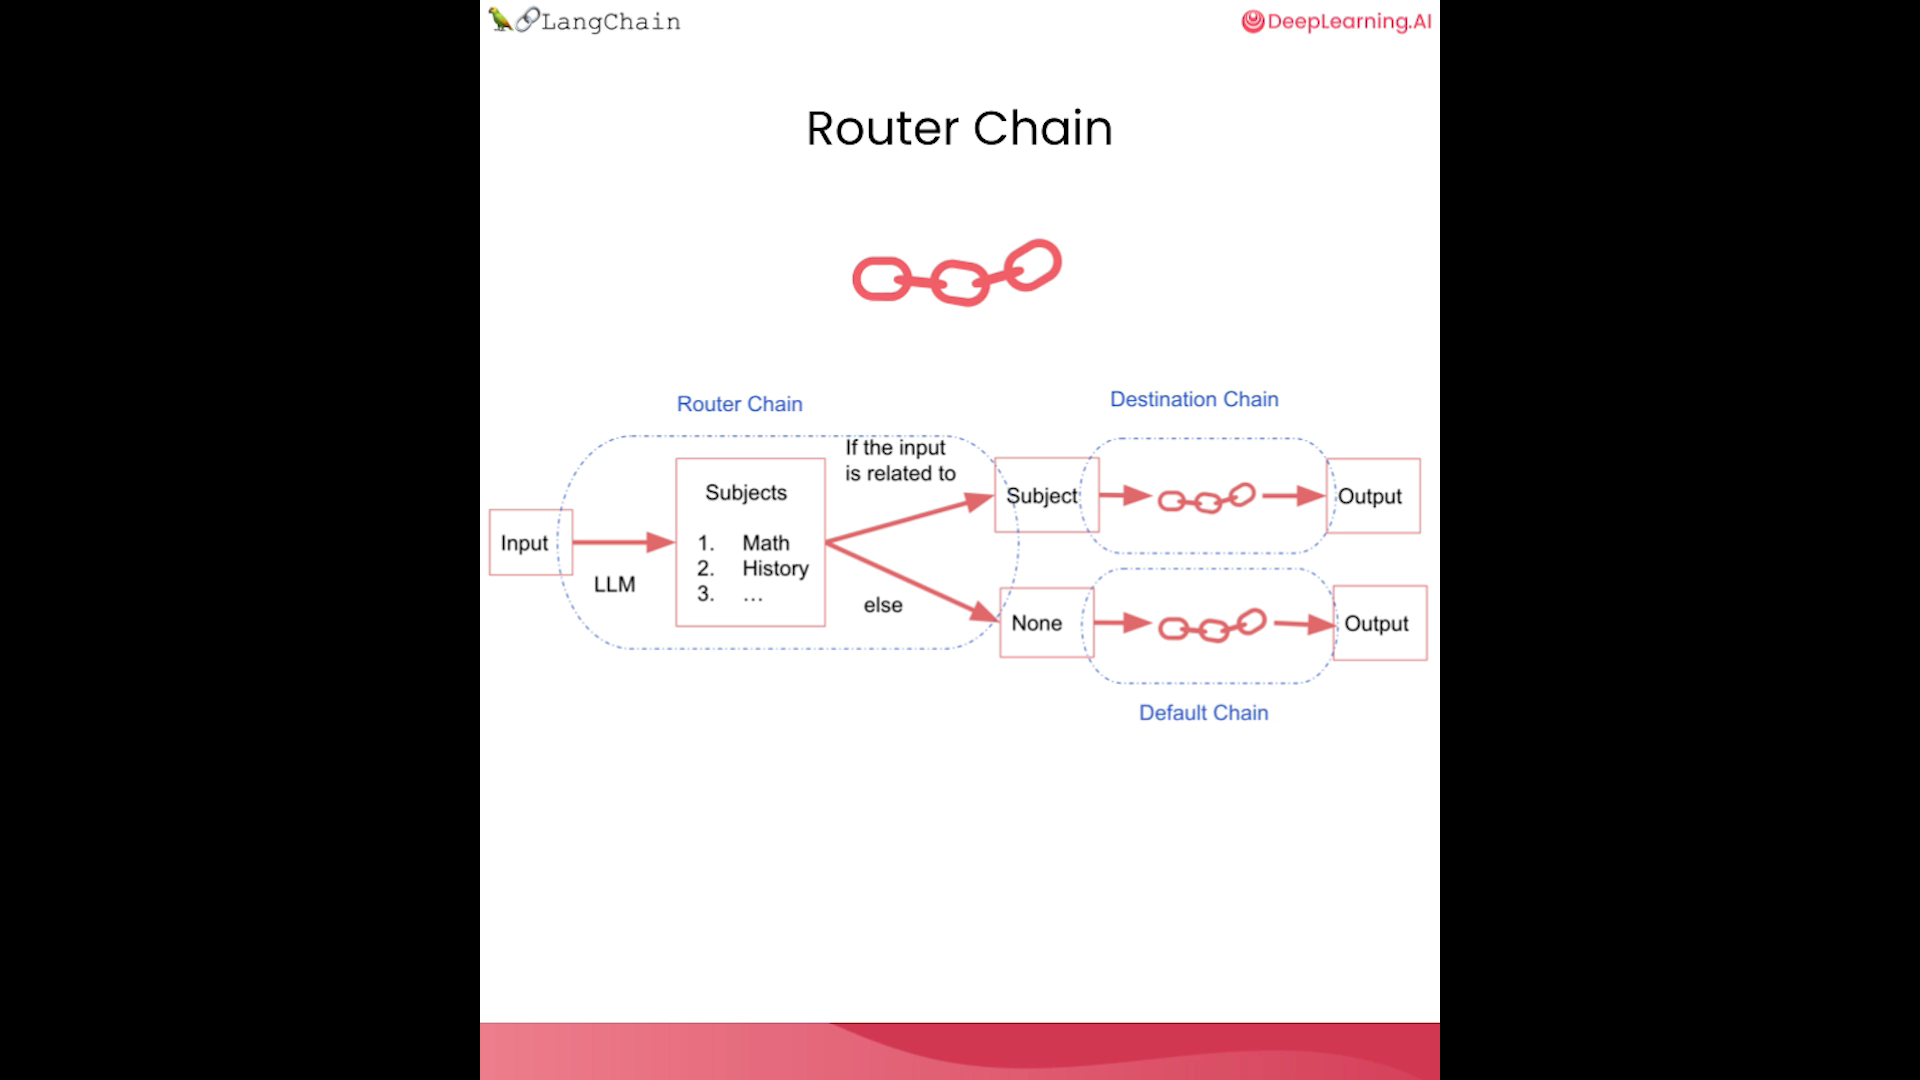

In [6]:
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise\
and easy to understand manner. \
When you don't know the answer to a question you admit\
that you don't know.

Here is a question:
{input}"""


math_template = """You are a very good mathematician. \
You are great at answering math questions. \
You are so good because you are able to break down \
hard problems into their component parts, 
answer the component parts, and then put them together\
to answer the broader question.

Here is a question:
{input}"""

history_template = """You are a very good historian. \
You have an excellent knowledge of and understanding of people,\
events and contexts from a range of historical periods. \
You have the ability to think, reflect, debate, discuss and \
evaluate the past. You have a respect for historical evidence\
and the ability to make use of it to support your explanations \
and judgements.

Here is a question:
{input}"""


computerscience_template = """ You are a successful computer scientist.\
You have a passion for creativity, collaboration,\
forward-thinking, confidence, strong problem-solving capabilities,\
understanding of theories and algorithms, and excellent communication \
skills. You are great at answering coding questions. \
You are so good because you know how to solve a problem by \
describing the solution in imperative steps \
that a machine can easily interpret and you know how to \
choose a solution that has a good balance between \
time complexity and space complexity. 

Here is a question:
{input}"""

In [7]:
prompt_infos = [
    {
        "name": "physics", 
        "description": "Good for answering questions about physics", 
        "prompt_template": physics_template
    },
    {
        "name": "math", 
        "description": "Good for answering math questions", 
        "prompt_template": math_template
    },
    {
        "name": "History", 
        "description": "Good for answering history questions", 
        "prompt_template": history_template
    },
    {
        "name": "computer science", 
        "description": "Good for answering computer science questions", 
        "prompt_template": computerscience_template
    }
]

In [8]:
from langchain.chains.router import MultiPromptChain ##When you have to route between  multiple different Prompts
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser ## LLM Router Chain uses LLM itself to route between multiple prompts
from langchain.prompts import PromptTemplate 

## RouterOutputParser - Parses output into dictionary . So that we can use it in downstream

In [9]:
llm = ChatOpenAI(temperature=0, model=llm_model)

## We will first create prompt and chains for all the prompts created and store the chain in destination chain
destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    prompt_template = p_info["prompt_template"]
    prompt = ChatPromptTemplate.from_template(template=prompt_template)
    chain = LLMChain(llm=llm, prompt=prompt)
    destination_chains[name] = chain  
    
destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)

In [10]:
destinations

['physics: Good for answering questions about physics',
 'math: Good for answering math questions',
 'History: Good for answering history questions',
 'computer science: Good for answering computer science questions']

In [11]:
destinations_str

'physics: Good for answering questions about physics\nmath: Good for answering math questions\nHistory: Good for answering history questions\ncomputer science: Good for answering computer science questions'

We will also create default chain when Router cannot decided what is the subject in question 

In [12]:
default_prompt = ChatPromptTemplate.from_template("{input}")
default_chain = LLMChain(llm=llm, prompt=default_prompt)

Now we will create template which will be used by Router to route between chains 

In [13]:
MULTI_PROMPT_ROUTER_TEMPLATE = """Given a raw text input to a \
language model select the model prompt best suited for the input. \
You will be given the names of the available prompts and a \
description of what the prompt is best suited for. \
You may also revise the original input if you think that revising\
it will ultimately lead to a better response from the language model.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ a potentially modified version of the original input
}}}}
```

REMEMBER: "destination" MUST be one of the candidate prompt \
names specified below OR it can be "DEFAULT" if the input is not\
well suited for any of the candidate prompts.
REMEMBER: "next_inputs" can just be the original input \
if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
{destinations}

<< INPUT >>
{{input}}

<< OUTPUT (remember to include the ```json)>>"""

In [14]:
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(
    destinations=destinations_str
)
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(),
)

router_chain = LLMRouterChain.from_llm(llm, router_prompt)

Now we will put everything together . We will pass all chains in MultiPromptChain

In [15]:
chain = MultiPromptChain(router_chain=router_chain, 
                         destination_chains=destination_chains, 
                         default_chain=default_chain, verbose=True
                        )

In [16]:
chain.run("What is black body radiation?")



> Entering new MultiPromptChain chain...
physics: {'input': 'What is black body radiation?'}
> Finished chain.


"Black body radiation refers to the electromagnetic radiation emitted by a perfect black body, which is an object that absorbs all radiation that falls on it and emits radiation at all wavelengths. The radiation emitted by a black body depends only on its temperature and follows a specific distribution known as Planck's law. This type of radiation is important in understanding the behavior of stars, as well as in the development of technologies such as incandescent light bulbs and infrared cameras."

In [17]:
chain.run("what is 2 + 2")



> Entering new MultiPromptChain chain...
math: {'input': 'what is 2 + 2'}

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing..



> Finished chain.


'As an AI language model, I can answer this question easily. The answer to 2 + 2 is 4.'

In [18]:
chain.run("Why does every cell in our body contain DNA?")



> Entering new MultiPromptChain chain...


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.co

None: {'input': 'Why does every cell in our body contain DNA?'}

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for gpt-3.5-turbo-0301 in organization org-LUDHtprj8OJ75TBCB59P7iIu on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.co


> Finished chain.


'Every cell in our body contains DNA because DNA carries the genetic information that determines the characteristics and functions of each cell. DNA contains the instructions for the synthesis of proteins, which are essential for the structure and function of cells. Additionally, DNA is responsible for the transmission of genetic information from one generation to the next. Therefore, every cell in our body needs DNA to carry out its specific functions and to maintain the integrity of the organism as a whole.'